# Solving the heat Equations

In [ ]:
import sys
import numba
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import random
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import cuda
from numba import njit, prange, jit
from scipy.sparse import coo_matrix
import pandas as pd
import seaborn as sb
from time import time
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numba
%matplotlib inline

plt.rcParams["figure.figsize"] = [7.00, 7.00]
plt.rcParams["figure.autolayout"] = True

##Functions

In [ ]:
def Plot_3D_Surface(u, N, colour, title):
  """
  Function returns a 3D plot of the plate in a 7x7 size image.
  """
  dx = 2/N
  fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
  x, y = np.meshgrid(np.arange(-1, 1, dx), np.arange(-1, 1, dx))
  if colour == True:
    plot = ax.scatter3D(x, y, u, c=u, linewidth=0, antialiased=True)
  else:
    plot = ax.scatter3D(x, y, u)
  ax.zaxis.set_major_locator(LinearLocator(3))
  ax.xaxis.set_major_locator(LinearLocator(3))
  ax.yaxis.set_major_locator(LinearLocator(3))
  ax.set_xlabel('X axis (-1,1)')
  ax.set_ylabel('Y axis (-1,1)')
  ax.set_zlabel('Temperature Axis in degrees$^{\circ}$')
  ax.set_title(title)
  plt.show()
  return

def Plot_2D_Heatmap(u, title):
  """
  Function returns a 2D plot of the plate in a 7x7 size image.
  """
  plt.imshow(u, extent=[-1, 1, -1, 1])
  plt.title(title)
  plt.colorbar()
  plt.show()
  return

@numba.jit(nopython=True, parallel=True)
def csr_matvec(data, indices, indptr, shape, x):
    """Evaluates the matrix-vector product with a CSR matrix."""
    m, n = shape
    y = np.zeros(m, dtype=np.float64)
    for row_index in numba.prange(m):
        col_start = indptr[row_index]
        col_end = indptr[row_index + 1]
        for col_index in range(col_start, col_end):
            y[row_index] += data[col_index] * x[indices[col_index]]
    return y

# Introduction and Problem

This discussion will cover the topics of finite differences, and solutions of differential equations. The posed problem is as follows:

A 2D heat plate of shape (2,2) is modelled along the x and y axis cantered in (0,0) such that the edges cover the square (-1, 1) in (x, y). One side is heated to $5^{\circ}$. Figure 1 shows that the temperature of the plate along the Y=1 side is 5$^{\circ}$ and is zero everywhere else.

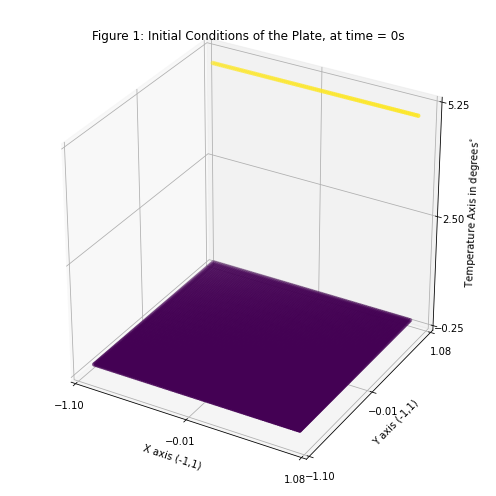

In [ ]:
u = np.zeros((100, 100))
u[-1, :] = 5
Plot_3D_Surface(u, 100, True, 'Figure 1: Initial Conditions of the Plate, at time = 0s')




















The goal will be to use the below equation to model heat flowing through this heat plate and calculate the time taken (t*) for the point (0,0) to reach 1$^{\circ}$. 

$$
u_t = \Delta u
$$

Boundary Conditions:

$$
u_{t=0}[1,:] = u_{t=0}[:, -1] = u_{t=0}[:, 1] = 0
$$
$$
u_{t=0}[-1,:] = 5
$$


Both Explicit and Implicit calculations will be used, so that the methods may be evaluated and compared. For illustrative purposes, Figure 2 below is the graph when allowed to go for time: t >> t*, this is the temperature distribution the system tends towards as $t \rightarrow \infty$. This is done with the Iterative Explicit method, which is described in the following section.

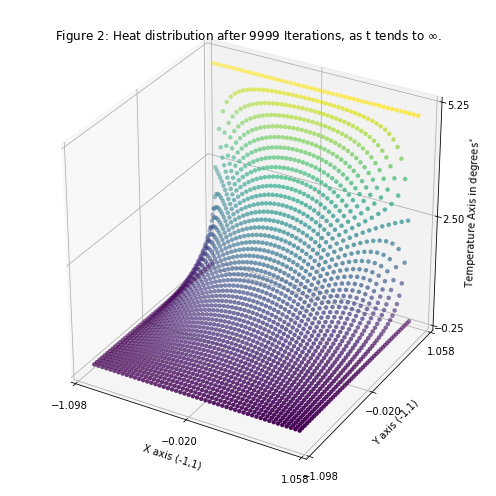

In [ ]:
N = 50
max_iter = 10000

dx = 2/N
dt = dx**2 / 4 
alpha = dt**2 / dx**4 
u = np.zeros((max_iter, N, N))
u[:,(N-1),:] = 5
half = int(np.rint(N/2))
time_elapsed = 0.
count = 0
while count < max_iter-1:
  for i in range(1, N-1):
    for j in range(1, N-1):
      u[count+1,i,j] = alpha *(u[count][i+1][j] + u[count][i-1][j] + u[count][i][j+1] + u[count][i][j-1] - 4*u[count][i][j]) + u[count][i][j]
  if u[count][half][half] == u[count-1][half][half] and u[count][half][half]!=0:
      u = u[count]
      break
  time_elapsed += dt
  count += 1

title = "Figure 2: Heat distribution after " +  str(count) + " Iterations, as t tends to $\infty$."
Plot_3D_Surface(u[-1], N, True, title)

# Explicit

## Iteration Method

The explicit method of solving this system uses the iterative method of Forward Difference (FD or Forward Euler). The system $u_t = \Delta u$ can be expanded to:
$$
u_t = \Delta u \rightarrow \frac{du}{dt} = \frac{d^{2}u}{dx^{2}}+\frac{d^{2}u}{dy^{2}} 
$$
Applying the Euler’s Forward Difference equations, and using the approximation:
$$
\frac{df}{dv} \approx \frac{u(v + \Delta v) - u(v)}{\Delta v} 
$$ 
gives:
$$
\frac{du}{dt} \approx \frac{u(t+dt)-u(t)}{dt} = \frac{u_{n+1} - u_n}{dt} 
$$
Letting $\frac{du}{dt} = \Delta u$:
$$
u_{n+1} = u_n + dt \Delta u
$$
Substitute $\Delta u$ using the iterative approximation:
$$
\Delta u_{i, j}\approx -\frac{4u_{i, j} - u_{i - 1, j} - u_{i + 1, j} - u_{i, j - 1} - u_{i, j+ 1}}{dx^2}
$$
gives:
$$
u_{n+1} = u_n - \frac{dt}{dx^2}[4u_{i, j} - u_{i - 1, j} - u_{i + 1, j} - u_{i, j - 1} - u_{i, j+ 1}]_{n}
$$
This is the iterative scheme that will be implemented. For completeness, it is simplified into a term-by-term iteration below, however it will not be used:
$$
u_{n+1} = u_n - \frac{dt}{dx^2}4u_{i, j} + \frac{dt}{dx^2}[u_{i - 1, j} + u_{i + 1, j} + u_{i, j - 1} + u_{i, j+ 1}]_{n}
$$
Using $u_{i,j} = u_n$ for the first 2 terms:
$$
u_{n+1} = (1-\frac{4dt}{dx^2})u_{i,j} + \frac{dt}{dx^2}[u_{i - 1, j} + u_{i + 1, j} + u_{i, j - 1} + u_{i, j+ 1}]_{n}
$$
So, to calculate the heat flowing through the plate, this iteration is running for N times, with each N+1 step moving through time dt. This discretises the time variable and means at each time step $(t+N*dt)$ the temperature distribution may be returned. 








Before a discussion of the algorithm, an analysis of the stability will be conducted. From the problem equation the solution
$$
u = u_0 e^{\lambda t}
$$
may be found. This is the general solution for this problem, and allows us to perturb $u_0$ by $\epsilon$ such that
$$
u_{0\epsilon} = u_0 + \epsilon
$$
and therefore
$$
u = (u_0 + \epsilon) e^{\lambda t}
$$
It can then be rewritten from the original equation
$$
u_{n+1} = u_n + dt \Delta u
$$
and the derivative
$$
\frac{du_{1\epsilon}}{dt} = \lambda (u_0 + \epsilon) e^{\lambda t}
$$
therefore
$$
u_{n+1\epsilon} = u_{n \epsilon} + \epsilon + dt \lambda (u_{0 \epsilon} + \epsilon) e^{\lambda t}
$$
Due to the final $\lambda$ term, $u_{n+1}$ becomes exponentially inaccurate and is unstable if $\lambda > 0$. If $\lambda \geq 0$ the error is small, so the solution is stable. To prevent this, a condition of 
$$
dt = \frac{dx^2}{4}
$$
is imposed. It is derived here. The expression 
$$
u_{n+1} = u_n + dt \Delta u
$$
has Eigenvalues in 2D
$$
\lambda_k = -\frac{1}{dx^2}8\sin^2{\frac{k\pi}{2(n+1)}}
$$
Using the maximum eigenvalue
$$
\lambda_{max} \approx \frac{8}{dx^2}
$$
and that 
$$
dt < \frac{2}{|\lambda_{max}|}
$$
dt may be found such that
$$
dt = \frac{2 dx^2}{8}
$$
ending the derivation of
$$
dt = \frac{dx^2}{4}
$$

This is implemented by calculating dt in each function. First dx is found by dividing 2 (length of each side) by N (discretisation points). dt is then defined as the above expression to ensure stability.

Another way of describing this is in terms of eigenvalues. If the equation 
$$
u_{n+1} = (1-\frac{4dt}{dx^2})u_{i,j} + \frac{dt}{dx^2}[u_{i - 1, j} + u_{i + 1, j} + u_{i, j - 1} + u_{i, j+ 1}]_{n}
$$
is taken and all eigenvalues are negative (which is required for all PDE's to converge) it is found that:
$$
1-4\frac{dt}{dx^2} \ge 0
$$
So that for a stable (converging solution) function:
$$
\frac{dx^2}{4} \ge dt 
$$

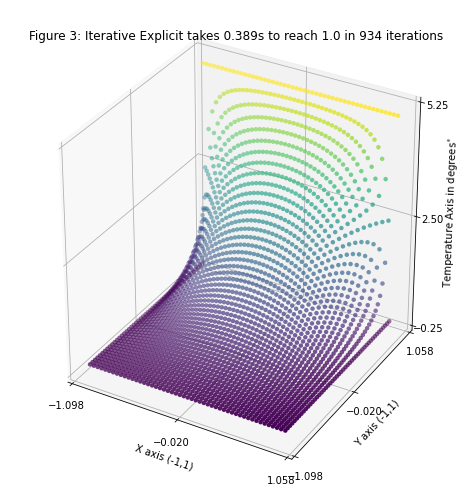

In [ ]:
def iterative_Explicit(N, max_iter, decimal, converge):
  """
  Inputs:
    - N is the 1D number of points in -1 to 1.
    - max_iter is the upper limit of iterations, to stop infinite loops.
    - decimal is to how many decimal places the point u(0,0) = 1.0...
    - converge is a Boolean dictating whether to stop iterating at u(0,0) = 1.


  This function discretizes a NxN grid, applies a Forward Difference Iterative 
  Scheme on a heat plate with one side at 5degrees. Returns the heat distribution
  when the center reaches 1degree or the number of iterations is maximised.
    - u is a 3D array with dimensions u[time][x][y]

  Outputs:
    - u is the final array of temperatures of size (N,N).
    - time_elapsed is the time taken to reach the result.
    - count is the number of dt's which elapsed.
    - u[half][half] rounded is the value of u(0,0), should output 1.0...
    - decimal is the decimal Input, returned.
    - center_temps is a list of the temperature at (0,0) at each step.
    """

  dx = 2/(N-1)                          #dx such that (N-1) dx's fit into (-1,1).
  dt = dx**2 / 4                        #Demands stability as dt < dx**2/(4*c).
  alpha = dt / dx**2                
  center_temps = []
  #Initial and Boudry Conditions.
  u = np.zeros((max_iter, N, N))                         
  u[:,(N-1),:] = 5                                       
  half = int(np.rint(N/2))

  time_elapsed = 0.
  count = 0
  #While less than maximum iterations, loop over x, y in (1, N-1).
  while count < max_iter-1: 
    for i in range(1, N-1): 
      for j in range(1, N-1):
        
        #For each iteration use the iterative scheme derived above.
        u[count+1,i,j] = u[count][i][j] + alpha *(u[count][i+1][j] 
                                                  + u[count][i-1][j] 
                                                  + u[count][i][j+1] 
                                                  + u[count][i][j-1] 
                                                  - 4*u[count][i][j])
    time_elapsed += dt
    count += 1
    center_temps.append(u[count][half][half])
    #Apply the test for point u(0,0) = 1.
    if converge and u[count][half][half] != 0 and np.round(u[count][half][half],
                                                           decimal) == 1.00:
      u = u[count]
      return u, time_elapsed, count, np.round(u[half][half],
                                              decimal), decimal, center_temps
  
  #Otherwise max_iter is reached and u(0,0) != 1.
  u = u[count]
  return u, time_elapsed, count, np.round(u[half][half],
                                          decimal), decimal, center_temps

res, time_elapsed, count, halfval, decimal, center_temps_iter =
                                         iterative_Explicit(50, 4000, 2, True)


                                         
title = "Figure 3: Iterative Explicit takes " + str(np.round(time_elapsed, 4)) +
       "s to reach " + str(halfval) + " in " + str(count) + " iterations"
Plot_3D_Surface(res, 50, True, title)

## Matrix Method

Alternatively for the explicit implementation, a slightly different method is used. To start with, the differential approximation is used:
$$
\frac{du}{dt} \approx \frac{u(t) - u(t - \Delta t)}{\Delta t} 
$$
As the differential should be approximately equivalent either side of t (assuming $\Delta t \rightarrow 0$) this is equivalent to the same previous forward difference discussed earlier. This can be re-represented in matrix form to
$$
\frac{du}{dt} = \frac{U_{n+1} - U_n}{\Delta t}
$$
If the derivative function is equal to another function $f(U, t)$, it can be written
$$
\frac{du}{dt} = f(U_{n+1}, t_{n+1}) = \frac{U_{n+1} - U_n}{\Delta t}
$$
Which becomes the matrix equation to solve through
$$
U_{n+1} = \Delta t f(U_{n+1}, t_{n+1}) + U_n
$$
$$
U_{n+1} = (1 + \Delta t f(U_{n+1}, t_{n+1}))U_n 
$$ 
$$
U_{n+1} = (1 + \Delta t f(U_{n+1}, t_{n+1}))^{n}U_0
$$ 
In the problem at hand, $f(U_{n+1}, t_{n+1})$ is simply the derivative of the f function with respect to x and y, so this becomes:
$$
U_{n+1} = (1 +\Delta t (\Delta u))^{n}U_0
$$
Where the matrix $\Delta u$ is a matrix which discretises the x,y derivatives with a 5-point stencil:
$$
\Delta u_{i, j}\approx -\frac{4u_{i, j} - u_{i - 1, j} - u_{i + 1, j} - u_{i, j - 1} - u_{i, j+ 1}}{dx^2}
$$
Note that dx = dy as this is a square problem. However, there is one more subtlety to address. The boundary conditions, as knowns, may be neglected from this system, and 'added back in' later. This saves time in moving the BC to the right-hand-side of the following system. From here, a matrix equation is created. Letting the $\Delta u = f_{ij}$ discretisation occur and rearranging gives
$$
-[4u_{i, j} - u_{i - 1, j} - u_{i + 1, j} - u_{i, j - 1} - u_{i, j+ 1}] = dx^2 \Delta u
$$

which can be turned into a system of equations by
$$
U_{n+1} = (1 - \Delta t \frac{4u_{i, j} - u_{i - 1, j} - u_{i + 1, j} - u_{i, j - 1} - u_{i, j+ 1}}{dx^2})^{n}U_0
$$
$$
U_{n+1} = (1 - \frac{\Delta t}{dx^2} [4u_{i, j} - u_{i - 1, j} - u_{i + 1, j} - u_{i, j - 1} - u_{i, j+ 1}])^{n}U_0
$$
Allowing $\alpha = \frac{dt}{dx^2}$ gives us a system of equations of the form:
$$
U_{n+1} = AU_n
$$
This means applying matrix A n times to $U_0$ transforms $U_0 \rightarrow U_{n+1}$. What is A though?
$$
A = \sum 1 - \alpha [4u_{i, j} - u_{i - 1, j} - u_{i + 1, j} - u_{i, j - 1} - u_{i, j+ 1}]
$$
And in matrix form:
$$
A: = 
\begin{pmatrix}
1-4\alpha&\alpha&0&\alpha&0&...&0\\
\alpha&1-4\alpha&\alpha&0&\alpha&...&0\\
0&\alpha&1-4\alpha&\alpha&0&...&0\\
...&...&...&...&...&...&\alpha\\
...&...&...&\alpha&1-4\alpha&\alpha&0\\
...&...&...&0&\alpha&1-4\alpha&\alpha\\
0&0&0&\alpha&0&\alpha&1-4\alpha
\end{pmatrix}
$$
This is a Diagonally-Symmetric matrix, with $1-4\alpha$ on the diagonals. On the Diagonals $\pm$ 1 there are $\alpha$ terms and on Diagonal $\pm$ N elements there are also $\alpha$ terms. these correspond to the iterative scheme described earlier.

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


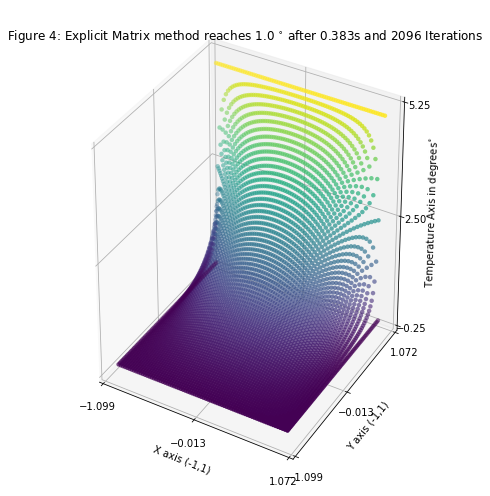

In [ ]:
@njit(fastmath = True, parallel = True)
def create_A_Explicit(N, alpha):
  """
  Inputs
    -  N = number of discretisation points per axis.
    - alpha = dt/ dx**2.
  
  This function creates the discretization matrix A as described above.

  Outputs:
    - A is a N**2 by N**2 matrix as derived above.
  """
  A = np.zeros((N**2, N**2))
  #Diagonal
  for n in prange(N**2): 
    A[n,n] = 1-4*alpha
  #Off Diagonal RHS
  for n in prange(0, N**2 -1): 
    A[n, n+1] = alpha
  #Off-Diagonal LHS
  for n in prange(1, N**2): 
    A[n,n-1] = alpha
  #Diagonal + N
  for n in prange(0, N**2 - N-1): 
    A[n,n+N] = alpha
  #Diagonal - N
  for n in prange(0, N**2 - N-1): 
    A[n+N,n] = alpha
  #Addings missing values on LHS
  for n in prange(1+N , N**2): 
    A[n,n-1] = alpha
  #Boundry Conditions
  #BC Upper
  for n in prange(N):
    A[n,:] = 0
  #BC Lower
  for n in prange((N-1)*N, N**2):
    A[n,:] = 0
    A[n,n] = 1
  #BC middle
  for n in prange(1,N-1):
    A[n*N,:] = A[n*N + N - 1,:] = 0
    A[n*N,n*N] = A[n*N + N - 1,n*N + N - 1] = 1
  return A

def Matrix_Explicit(N, max_iter, decimal, converge):
  """
  Inputs:
    - N is the 1D number of points in -1 to 1.
    - max_iter is the upper limit of iterations, to stop infinite loops.
    - decimal is to how many decimal places the point u(0,0) = 1.0.
    - coverage is a Boolean which dictates whether to stop at u(0,0) = 1.

  This function discretizes a NxN grid, applies a Forward Difference Matrix 
  Scheme on a heat plate with one side at 5degrees. Each iteration a matrix 
  system Au=b where A is made by create_A_Explicit and b is the last iteration 
  of u. Returns the heat distribution when the center reaches 1 degree or the 
  number of iterations is maximised.
    - u is a 3D array with dimensions u[time][x][y].

  Outputs:
    - u is the final array of temperatures of size (N,N).
    - time_elapsed is the time taken to reach the result.
    - count is the number of dt's which elapsed.
    - u[half][half] rounded is the value of u(0,0), should output 1.0...
    - decimal is the decimal Input, returned.
    - center_temps is a list of the temperature at (0,0) at each step.
    """
  dx = 2/(N-1)                    #Initial setup, identical to iteration method.
  dt = dx**2 / 4                        
  alpha = dt/ dx**2               
  u = np.zeros((max_iter, N, N))                         
  u[:,(N-1),:] = 5                                       
  half = int(np.rint(N/2))

                       #A is a CSR matrix created by create_A_Explicit function.
  A = csr_matrix(create_A_Explicit(N, alpha))
  b = np.zeros(N**2)               #b is the 'last' u, at the start b == u[t=0]. 
  b = u[0].flatten()

  center_temps = []
  time_elapsed = 0.
  count = 0
  while count < max_iter-1: 
    b = u[count].flatten()                     #Matrix b(NxN) -> vector b(N**2). 
                             #Solving the system returns the next value u_{n+1}.
    u[count+1] = (A @ b).reshape(N,N)         
    time_elapsed += dt
    count += 1
    center_temps.append(u[count][half][half])
    #Running the u(0,0) == 1 test
    if converge and u[count][half][half] != 0 and np.round(u[count][half][half], decimal) == 1.00:
      u = u[count]
      return u, time_elapsed, count, np.round(u[half][half], decimal), decimal, center_temps
  u = u[count]
  return u, time_elapsed, count, np.round(u[half][half], decimal), decimal, center_temps


res, time_elapsed, count,  round, decimal, center_temps_mat = Matrix_Explicit(75, 200000, 3, True)

title = "Figure 4: Explicit Matrix method reaches " + str(round) + " $^{\circ}$" + " after " + str(np.round(time_elapsed, 3)) + "s and " + str(count) + " Iterations"
Plot_3D_Surface(res, 75, True, title)



















##GPU Method

With the above method, a linear system of equations is created from A and $u_n$, to create $u_{n+1}$. This is multiplied out in a matrix, and is slow for large matrices, as evidenced in Assignment 1. Therefore, any attempt to speed up the process should start with the A @ b line of code. Here, Graphical Processing Units (GPUs) are utilised to achieve this speedup.


Figure 5 below showcases the 'proof of concept' of the GPU, the fact it returns reasonable answers.

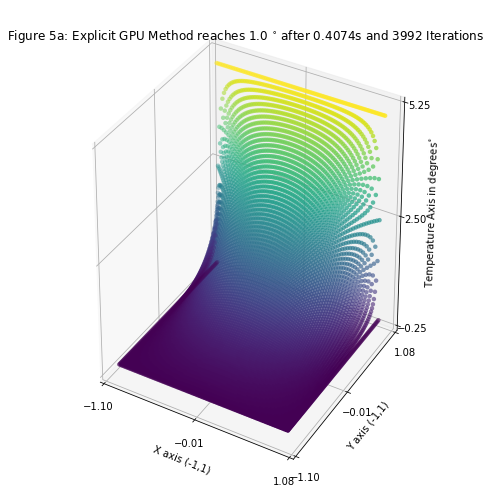

In [ ]:
@cuda.jit
def GPU_Iterate(n_row, data, indices, indptr, u_gpu, u1_gpu):
  """
  Inputs: (passed to GPU)
    - n_row = the number of rows.
    - data, indices & indptr = CSR Matrix info.
    - u_gpu = vector of u[count] size N**2.
    - u1_gpu = 'next' vector of u[count] size N**2.
    - max_iter = max number of iterations. 
    - timer = variable to pass the timer.
  
  This GPU accelerated function loops through rows and columns of the A matrix 
  via the indptr array. It uses the indices at each iteration to get the correct 
  u elements and multiplies it by the corresponding A data. Adding this to the 
  next u1 element at each row. 

  Outputs:
    - No Outputs, as GPUs 'return' nothing.
  """
  #Calculating the Tread Index and Row number.
  tx = cuda.threadIdx.x
  bx = cuda.blockIdx.x
  row = SX*bx + tx

  cuda.syncthreads()
  #Iterate over rws and columns.
  if row < n_row:
    temp_array = 0.

    #Loop between start_column=indptr[row] -> end_colum=indptr[row+1].
    for element in range(indptr[row],indptr[row+1]):

      #Matrix Multiply in CSR format.
      temp_array += u_gpu[indices[element]] * data[element]

    #Assigning u1's new row from the temporary holder.
    u1_gpu[row] = temp_array
    cuda.syncthreads()

def GPU_Explicit(N, max_iter, decimal, converge):
  """
  Inputs:
    - N is the 1D number of points in -1 to 1.
    - max_iter is the upper limit of iterations, to stop infinite loops.
    - decimal is to how many decimal places the point u(0,0) = 1.0.
    - coverage is a Boolean which dictates whether to stop at u(0,0) = 1.
  
  This function discretizes a NxN grid, applies a Forward Difference Matrix 
  Scheme on a heat plate with one side at 5 degrees. Each iteration a matrix 
  system Au=b where A is made by create_A_Explicit and b is the last iteration 
  of u, then multiplied with a GPU. Returns the heat distribution when the 
  center reaches 1 degree or the number of iterations is maximised.
    - u is a 2D array with dimensions u[x][y], such that t = n.
    - u1 is a 2D array with dimensions u[x][y], such that t = n+1.
    - REMEMBER to define SX, SY as global variables before calling the function 
      like so:
      SX = 512
      SY = SY = 4*(N-1)+5*(N-2)**2
      GPU_Explicit(N, 15000, 3, True)
    - Please check comments in previous functions, as not every line has 
      been changed.

  Outputs:
    - u is the final array of temperatures of size (N,N).
    - time_elapsed is the time taken to reach the result.
    - count is the number of dt's which elapsed.
    - u[half][half] rounded is the value of u(0,0), should output 1.0...
    - decimal is the decimal Input, returned.
    - center_temps is a list of the temperature at (0,0) at each step.
  """
  #SX and SY must be global variables.
  nblocks = (N**2 + SX-1)//SX

  dx = 2/(N-1)          
  dt = dx**2 / 4        
  alpha = dt / dx**2 

  #The GPU works best on the CSR matrix (Assignment 3) so use csr_matrix(array).
  A = csr_matrix(create_A_Explicit(N, alpha))
  u = np.zeros((N, N))  
  u[(N-1),:] = 5 
  half = int(np.rint(N/2))
  center_temps = []

  #u must be flattened so it is indexed efficiently regarding memory locality 
  #by the GPU.
  u = u.flatten()

  #u1 is the (for now) empty array of u[n+1] temperatures.
  u1 = np.zeros((N**2))

  #res is the final, 3D matrix analogus to 'u' in previous functions.
  res = np.zeros((max_iter, N,N))

  #u1 must be passed to the GPU once, as it can be recycled within the GPU.
  u1_gpu = cuda.to_device(u1)
  time_elapsed = 0.
  for count in range(max_iter):
    #Passing u to the GPU each iteration as it is updated.
    u_gpu = cuda.to_device(u)

    #Calling the GPU kernal.
    GPU_Iterate[(nblocks,1),(SX,1)](u.shape[0], A.data, A.indices,
                                    A.indptr, u_gpu, u1_gpu)

    #Pull data back from GPU (note->this is a vector).
    u = u1_gpu.copy_to_host()
    time_elapsed += dt
    
    #convert the next iteration of res to a reshaped u matrix (u:N**2->res:N,N).
    res[count] = u.reshape(N,N)
    center_temps.append(res[count][half][half])
    if converge and res[count][half][half] != 0 and np.round(res[count][half][half], decimal) == 1.00:
      res = res[count]
      return res, time_elapsed, count, np.round(res[half][half], decimal), decimal, center_temps
  res = res[count]
  return res, time_elapsed, count, np.round(res[half][half], decimal), decimal, center_temps

N = 100
SX = 512
SY = SY = 4*(N-1)+5*(N-2)**2 #Number of internal non-zero points
res, time_elapsed, count, round, decimal, center_temps_GPU =
                                                 GPU_Explicit(N, 20000, 3, True)

title = "Figure 5a: Explicit GPU Method reaches " + str(round) + " $^{\circ}$" +
 " after " + str(np.round(time_elapsed, 4)) + "s and " + str(count) +
  " Iterations"
Plot_3D_Surface(res, N, True, title)

Having proved its possible use, is it faster? Below trends in calculation time are discussed with respect to matrix size (NxN) and BlockSize.


It is expected that larger matrices will take longer to calculate as the required calculations scale with the square of N. It is expected that the ThreadSize will generally trend down, but oscillations will occur in multiples of 32. This is because it is faster to run many threads on a few blocks than to run many blocks with few threads. Each warp has 32 threads, so 'left over' threads are pushed to another, reducing the overall efficiency due to the wasted cycles in the unused threads. This means ever 32 threads the efficiency spikes and every 33rd thread the efficiency troughs. Each N or SX will probably have a large range between the best and worst times, and these will be telling of how reliable the GPU is.

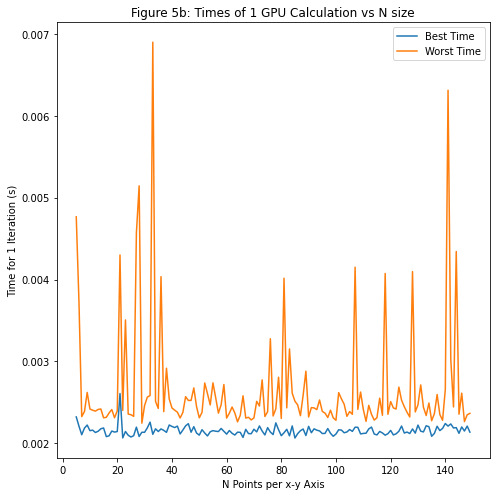

In [ ]:
Ns = np.arange(5,150)
SX = 512
times_best, times_worst, times_ave = [], [], []

#Loops over N: 5 -> 150, and times the GPU kernal.
for n in Ns: 
  max_iter = 500
  nblocks = (N**2 + SX-1)//SX
  timer = 0
  dx = 2/(N-1)          
  dt = dx**2 / 4        
  alpha = dt**2 / dx**4 
  A = csr_matrix(create_A_Explicit(N, alpha))
  u = np.zeros((N, N))  
  u[(N-1),:] = 5 
  u = u.flatten()
  half = int(np.rint(N/2))
  center_temps = []
  v = np.zeros((N**2))
  n = np.zeros((max_iter, N,N))
  v_gpu = cuda.to_device(v)
  u_gpu = cuda.to_device(u)
  time = %timeit -oq GPU_Iterate[(nblocks,1),(SX,1)](u.shape[0], A.data,
                                                     A.indices, A.indptr, 
                                                     u_gpu,v_gpu)
  times_best.append(time.best)
  times_worst.append(time.worst)
plt.plot(Ns, times_best, label = 'Best Time')
plt.plot(Ns, times_worst, label = 'Worst Time')
plt.title("Figure 5b: Times of 1 GPU Calculation vs N size")
plt.xlabel("N Points per x-y Axis")
plt.ylabel("Time for 1 Iteration (s)")
plt.legend()































As expected in Figure 5b, there is a large range between the best and worst repeats at each N value. Although the range is mostly less than 0.003s, occasional spikes cause the efficiency to drop. This is due to a couple of possibilities. Firstly, these seem to occur in groups, indicating that there is some N value around which efficiency falls. Note that although the area between N = 20 and N = 40 is very volatile, N = 32 is the best time among the worst times data. This indicates that 32 is important for the reasons stated above, however the slow groups are not always cantered around multiples of 32. For example, around N = 64 there is an area of quick calculations. This is possibly because now there are 2 warps, so the partially full one has its inefficiency averaged out by the full one. This is supported when N = 95 and the inefficiencies arise again. There is also a very fast run time at N = 125 followed by a slow one at N = 130, suggesting that that the 30 wasted threads at 130 make the 3 wasted loops at 125 look faster.


Below in Figure 5c the best times are plotted for SX between 5 and 600. The goal here is to see if a multiple of the discretization points (N) gives a performance gain. This would be because each block size holds a multiple of N data points. N was tested in multiples of 5 to see how the change from N=50->55 impacts the performance while ensuring repeats of the experiment at N=100->105 etc. This is not observed, as the slowest times occur around SX = N (50) and SX = 6*N (300). After plotting the best/worst times for each BlockSize (SX in the code) large ranges are evident. The time per calculation fluctuates by more than 100% when changing SX. On further inspection however, the overall trend of decreasing time is shown. The slowest time ( ≈0.0065s ) occurs within 4 iterations (N=20) and the slowest times continue decreasing from there to only  ≈0.003s  at  N≈510 . This overall trend shows (counter-intuitively) that the GPU runs faster on larger matrices. The writer does not understand why this may be the case, however it may be due to the sparse nature of the CSR matrices. Between N=50->55 the number of elements increases by 525 however the non-zero number increases by $\approx 5.25$ this means the change in calculation number is very small as N increases by 5, due to the CSR format

.

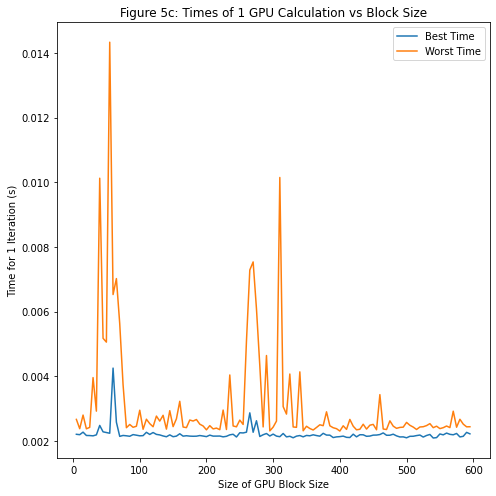

In [ ]:
SXs = np.arange(5,600, 5)
SX_times_best, SX_times_worst, times_ave = [], [], []

#Loops over SX: 5 ->600 in 5s, and times the GPU kernal.
for SX in SXs:
  N = 50
  nblocks = (N**2 + SX-1)//SX
  timer = 0
  dx = 2/(N-1)          
  dt = dx**2 / 4        
  alpha = dt**2 / dx**4 
  A = csr_matrix(create_A_Explicit(N, alpha))
  max_iter = 500
  u = np.zeros((N, N))  
  u[(N-1),:] = 5 
  u = u.flatten()
  half = int(np.rint(N/2))
  center_temps = []
  v = np.zeros((N**2))
  n = np.zeros((max_iter, N,N))
  v_gpu = cuda.to_device(v)
  u_gpu = cuda.to_device(u)
  time = %timeit -oq GPU_Iterate[(nblocks,1),(SX,1)](u.shape[0], 
                                                     A.data, A.indices, 
                                                     A.indptr, u_gpu,v_gpu)
  SX_times_best.append(time.best)
  SX_times_worst.append(time.worst)
plt.plot(SXs, SX_times_best, label = 'Best Time')
plt.plot(SXs,  SX_times_worst, label = 'Worst Time')
plt.title("Figure 5c: Times of 1 GPU Calculation vs Block Size")
plt.xlabel("Size of GPU Block Size")
plt.ylabel("Time for 1 Iteration (s)")
plt.legend()




















##What time does this method calculate for $u(0,0) = 1^{\circ}$

The above function is used to calculate the time taken for the centre to reach 1^{\circ}. Using a discretization grid of 150 points per axis (22,500 in total) and such that the value is returned when the centre rounds to 1.000 (3 decimal points).

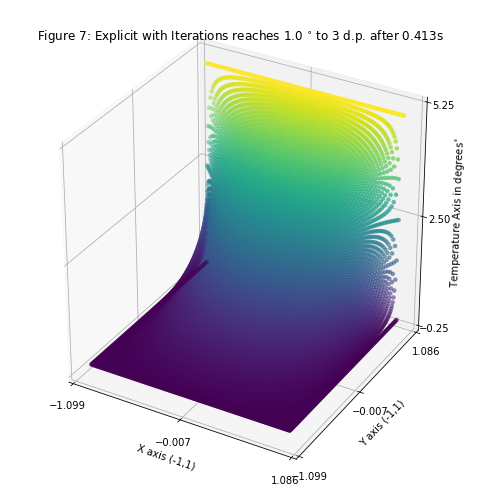

In [ ]:
N = 150
SX = 512
SY = SY = 4*(N-1)+5*(N-2)**2 #Number of internal non-zero points
res, time_elapsed, count, round, decimal, center_temps_GPU = 
                                          GPU_Explicit(N, 2*(N**2), 3, True)

title = "Figure 7: Explicit with Iterations reaches " + str(round) +
 " $^{\circ}$" + " to " + str(decimal) + " d.p." + " after " +
  str(np.round(time_elapsed, 4)) + "s" 
Plot_3D_Surface(res, N, True, title)

# Implicit

## Naive Method

Because of the stability issue discussed earlier, an alternative more stable method must be found. This is done in the Implicit (Backwards Euler) method.

Beginning with the backwards Euler equation
$$
\frac{du}{dt} = \frac{u(t)-u(t-\Delta t)}{\Delta t}
$$ 
in matrix form
$$
f(U_{n+1}, t_{n+1}) = \frac{U_{n+1}-U_n}{\Delta t}
$$
This can be rearranged to give the equation
$$
U_{n+1} = U_n + dtf(U_{n+1}, t_{n+1})
$$
which may be further rewritten using the discretisation 
$$
U_{n+1} = (1 - dtf(U_{n+1}, t_{n+1}))U_n
$$
Therefore, a similar discretisation matrix to the Explicit method may be created
$$
A: = 
\begin{pmatrix}
1+4\alpha&-\alpha&0&-\alpha&0&...&0\\
-\alpha&1+4\alpha&-\alpha&0&-\alpha&...&0\\
0&-\alpha&1+4\alpha&-\alpha&0&...&0\\
...&...&...&...&...&...&-\alpha\\
...&...&...&-\alpha&1+4\alpha&-\alpha&0\\
...&...&...&0&-\alpha&1+4\alpha&-\alpha\\
0&0&0&-\alpha&0&-\alpha&1+4\alpha
\end{pmatrix}
$$
From the above equation, the stability may be examined, through the rearrangement
$$
U_n = U_{n+1} - dtf(U_{n+1}, t_{n+1})
$$
$$
U_n = U_{n+1} - dt\alpha U_{n+1} = U_{n+1} (1-dt\alpha)
$$
$$
U_{n+1} = \frac{1}{1-dt\alpha} U_n
$$
For convergence to occur, $\frac{1}{1-dt\alpha} < 1$, and because $\alpha > 0$, this is always stable.

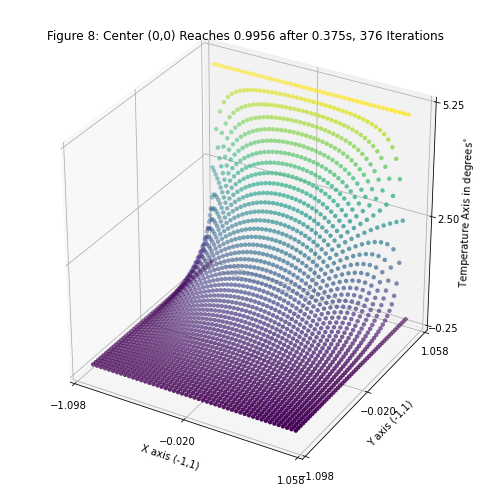

In [ ]:
@njit(fastmath=True, parallel=True)
def create_A_implicit(N, alpha):
  """
  Inputs
    -  N = number of discretisation points per axis.
    - alpha = dt/ dx**2.
  
  This function creates the discretization matrix A as described above.
    - Please see the previous Explicit discretisation matrix 
      for identical commenting. Main difference is: alpha -> -alpha.

  Outputs:
    - A is a N**2 by N**2 matrix as derived above.
  """
  A = np.zeros((N**2, N**2))
  for n in prange(N**2):
    A[n,n] = 1+4*alpha
  for n in prange(0, N**2 -1):
    A[n, n+1] = -alpha
  for n in prange(1, N**2):
    A[n,n-1] = -alpha
  for n in prange(0, N**2 - N-1):
    A[n,n+N] = -alpha
  for n in prange(0, N**2 - N-1):
    A[n+N,n] = -alpha
  for n in prange(1+N , N**2):
    A[n,n-1] = -alpha
  for n in prange(N):
    A[n,:] = 0
    A[n,n] = 1
  for n in prange((N-1)*N, N**2):
    A[n,:] = 0
    A[n,n] = 1
  for n in prange(1,N-1):
    A[n*N,:] = A[n*N + N - 1,:] = 0
    A[n*N,n*N] = A[n*N + N - 1,n*N + N - 1] = 1
  return A

def implicit(N, dt, max_iter, decimal, converge):
  """
  Please see CSR version below for a breakdown, this is included for comparison 
  purposes. They are identical except for the A being in CSR form.
  """
  dx = 2/N
  u = np.zeros((max_iter, N, N))
  u[:,(N-1),:] = 5 
  u[:,(0),:] = u[:,:,0] = u[:,:,(N-1)] = 0  
  half = int(np.rint(N/2)) 
  alpha = dt / dx**2
  b = np.zeros((N**2), dtype = 'float64')
  A = create_A_implicit(N, alpha)
  count = 1
  time_elapsed = 0
  center_temps = []
  while count < max_iter-1:
    b = u[count]
    b[(N-1),:] = 5 
    b[0,:] = b[:,0] = b[:,(N-1)] = 0
    b = b.flatten()
    u[count+1] = scipy.linalg.solve(A, b).reshape((N,N))
    count += 1
    time_elapsed += 1
    center_temps.append(u[count, half, half])
    if converge and u[count, half, half] != 0 and np.round(u[count, half, half], decimal) == 1:
      u = u[count]
      return u, A, b, time_elapsed*dt, count, u[half][half], center_temps
  u = u[count]
  return u, A, b, time_elapsed*dt, count, u[half][half], center_temps

u, A, b, time, count, halfval, center_temps = implicit(50, 0.001, 500, 2, True)
title = 'Figure 8: Center (0,0) Reaches '+ str(np.round(halfval ,4)) +' after '+ str(time)+ 's, '+ str(count)+' Iterations'
Plot_3D_Surface(u, 50, True, title)















## CSR Method

The above method is very slow, Figure 8 needed 6 minutes to execute. This is because solving a NxN matrix requires exponentially many calculations. To improve on this, a CSR format of A is used and executed below. CSR formatting offers large benefits here as A is very sparse and has (almost) constant elements per line so padding is minimal. Scipy's sparse solver is very fast (see Assignment 2).

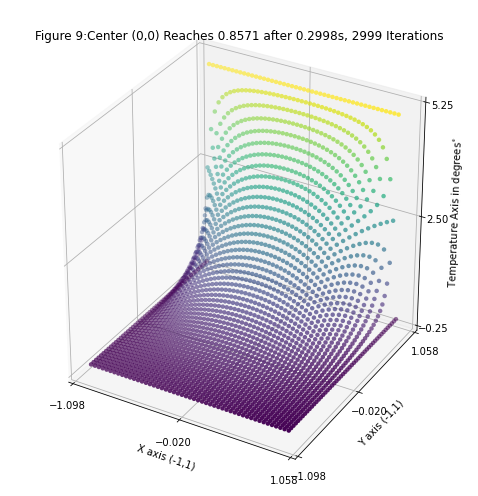

In [ ]:
def CSR_implicit(N, dt, max_iter, decimal, converge):
  """
  Inputs:
    - N is the 1D number of points in -1 to 1.
    - dt is the time step size it is a variable and is unrestricted. 
    - max_iter is the upper limit of iterations, to stop infinite loops.
    - decimal is to how many decimal places the point u(0,0) = 1.0...
    - converge is a Boolean dictating whether to stop iterating at u(0,0) = 1.

  This algorithm uses a Backward Euler method to return the distribution of 
  temperature at the center (0,0) until it reaches 1 degree. It uses a CSR 
  formatted discretisation matrix and solves it for each iteraion (time step). 
  The size of the timestep may be chosen as this is stable for all sizes of dt.

  Outputs:
    - u is the final array of temperatures of size (N,N).
    - A = discretisation matrix of size (N**2, N**2).
    - b = vector which is solved size N**2.
    - time_elapsed is the time taken to reach the result.
    - count is the number of dt's which elapsed.
    - u[half][half] rounded is the value of u(0,0), should output 1.0...
    - decimal is the decimal Input, returned.
    - center_temps is a list of the temperature at (0,0) at each step.
    """
  #Setup
  dx = 2/N
  u = np.zeros((max_iter, N, N))
  u[:,(N-1),:] = 5 
  u[:,(0),:] = u[:,:,0] = u[:,:,(N-1)] = 0  
  half = int(np.rint(N/2)) 
  alpha = dt / dx**2

  #Initialise A, b
  b = np.zeros((N**2), dtype = 'float64')
  A = csr_matrix(create_A_implicit(N, alpha))

  count = 1
  time_elapsed = 0
  center_temps = []
  while count < max_iter-1:
    #Set this value of u to b, and make b become u_n.
    b = u[count]

    #Set the Boundary Conditions (included for redundency).
    b[(N-1),:] = 5 
    b[0,:] = b[:,0] = b[:,(N-1)] = 0

    #As b is solved with A, it must be a N**2 vector.
    b = b.flatten()

    #Solve Ab = u[count+1] with sparse solver.
    u[count+1] = spsolve(A, b).reshape((N,N))

    count += 1
    time_elapsed += 1
    center_temps.append(u[count, half, half])
    #Usual tests.
    if converge and u[count, half, half] != 0 and np.round(u[count, half, half], decimal) == 1:
      u = u[count]
      return u, A, b, time_elapsed*dt, count, u[half][half], center_temps
  u = u[count]
  return u, A, b, time_elapsed*dt, count, u[half][half], center_temps

u, A, b, time, count, half_value, center_temps_CSR = CSR_implicit(50, 0.0001, 5000, 3, True)
title = 'Figure 9:Center (0,0) Reaches '+ str(np.round(half_value,4)) +' after '+ str(time)+ 's, '+ str(count)+' Iterations'
Plot_3D_Surface(u, 50, True, title)

##What time does this method calculate for $u(0,0) = 1^{\circ}$

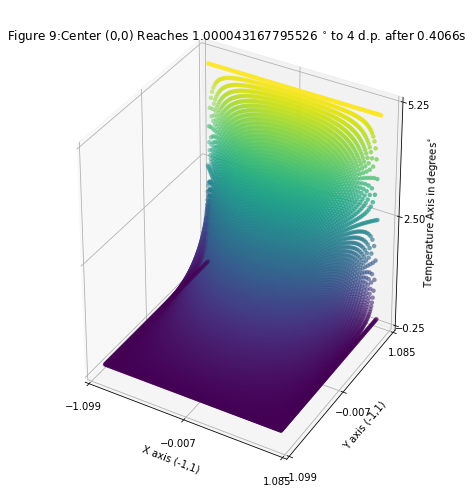

In [ ]:
N = 140
round_to = 4

u, A, b, time, count, half_value, center_temps_CSR = 
                    CSR_implicit(N, 0.0001, 2*(N**2), round_to, True)
title = 'Figure 9:Center (0,0) Reaches '+ str(half_value) +
 " $^{\circ}$" + " to " + str(round_to) + " d.p." + " after " +
  str(np.round(time, 5)) + "s"

Plot_3D_Surface(u, N, True, title)

















# Experiments

##Benchmarking

The first step in benchmarking these algorithms and compare their performance it to look at the time to run the functions. 

In [ ]:
print("Explicit-Matrix Method computing time:")
%timeit Mat_Ex_res, Mat_Ex_time_elapsed, Mat_Ex_count,  Mat_Ex_halfval, decimal,
                    Mat_Ex_temps = Matrix_Explicit(50, 200, 2, True)
print("\n")
print("Explicit-Iterative Method computing time:")
%timeit It_Ex_res, It_Ex_time_elapsed, It_Ex_count, It_Ex_halfval, decimal,
                     It_Ex_temps = iterative_Explicit(50, 200, 2, True)
print("\n")
N = 50
SX = 512
SY = SY = 4*(N-1)+5*(N-2)**2
print("Explicit-GPU Method computing time:")
%timeit GPU_Ex_res, GPU_Ex_time_elapsed, GPU_Ex_count, GPU_Ex_round, decimal,
                     GPU_Ex_center_temps = GPU_Explicit(N, 200, 2, True)
print("\n")
print("Implicit Naive Method computing time:")
%timeit Nai_Imp_res, Nai_Imp_A, Nai_Imp_b, Nai_Imp_time_elapsed, Nai_Imp_count,
        Nai_Imp_half_value, Nai_Imp_temps = implicit(50, 0.0001, 200, 2, True)
print("\n")
print("Implicit CSR Method computing time:")
%timeit CSR_Imp_res, CSR_Imp_A, CSR_Imp_b, CSR_Imp_time_elapsed, CSR_Imp_count,
      CSR_Imp_half_value, CSR_Imp_temps = CSR_implicit(50, 0.0001, 200, 2, True)

Explicit-Matrix Method computing time:
The slowest run took 59.91 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 65.9 ms per loop


Explicit-Iterative Method computing time:
1 loop, best of 5: 2.17 s per loop


Explicit-GPU Method computing time:
1 loop, best of 5: 617 ms per loop


Implicit Naive Method computing time:
1 loop, best of 5: 1min 41s per loop


Implicit CSR Method computing time:
1 loop, best of 5: 1.62 s per loop


In the Implicit method, a linear system of equations is solved at each iteration, which is a computationally heavy process. This means it is expected to be the slowest process. As expected, the naive Implicit method was slowest at 101s per run. 


The Explicit method is much faster at 2.17s, as no 'heavy duty' calculations are done. In the iteration scheme the program is slowed by the many indices and arrays. Because these are not always efficiently stored regarding memory locality, retrieving information from an array is a slow process. 

This is improved upon somewhat by the CSR method to 1.62s, by using the sparse solver where the naive Implicit was slowest. As discussed in Assignment 2, storing large dense matrices is memory heavy. Therefore, when working with sparse matrices, CSR format is less memory intensive. It follows that it is easier to index CSR formatted matrices than dense formatted ones of same size N.   


The Explicit matrix method removes this repetitive indexing of the iterative explicit method and instead multiplies a matrix by each iteration. This has its own problems as matrix vector multiplication calculation times scale exponentially with the number of elements, but still demonstrates a huge improvement requiring just (65.9ms) 3% of the iterative scheme’s calculation time. Despite this improvement, the issue of speed volatility cannot be ignored. The slowest runtime took 59.91 times the fastest, taking 3.94s. This is slower than the fastest iterative scheme, and is likely due to the large N matrix multiplication taking exponentially longer than small N. Not forcing memory locality also impedes this function as for large N, A and b (size $(N^2,N^2)$ and ($N^2$) may not be stored in the RAM. 


This may be improved by utilising GPUs to find the matrix vector products. Doing these calculations in parallel means this whole process is optimised. Memory locality of the vector and array may also be ensured within the GPU kernel. This reduced the volatility of calculations, but scaled the calculation times by 9.36, as the GPU Explicit method took 617ms to run.


Below Figure 10 is the temperature curve of point (0,0) over iteration times. Please note here that as dt may change for different functions, the iteration time is used. Specifically in Figure 10, $dt = \frac{dx^2}{4}$ to ensure stability in the Explicit methods, but this may not always be the case, as the CSR Implicit method may have a user defined dt. In Figure 0 it can be observed that every algorithm agrees (within a very small tolerance) on the temperature curve of the central point. The tending to $\approx 1.24^{\circ}$ and the exponential upwards curve agrees with the writers current understanding of temperature flows through materials. It is worth noting that while they are all close together (the Explicit Matrix and Explicit Iterative methods are 'invisible on the graph) the Explicit GPU method seems to slightly lag behind the others, particularly in the 'corner just below $1.2^{\circ}$. This is possibly due to the BlockSizes being not optimised. 512 was used as it is a standard, however this should not vary the temperature, only the calculation time. It may also be explained by the width of the lines on the chart.


Text(0, 0.5, 'Temperature in $^{\\circ}$C')

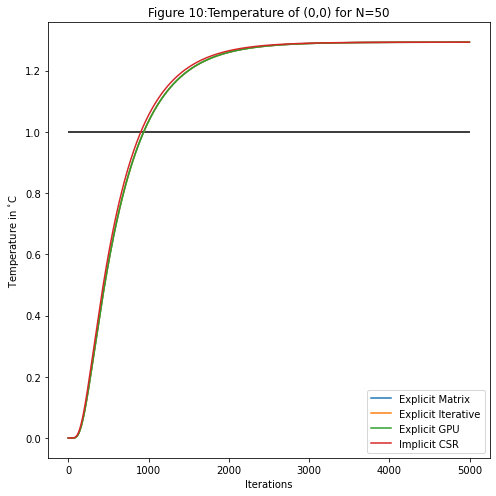

In [ ]:
N = 50
SX = 512
SY = 4*(N-1)+5*(N-2)**2
iterations =  2 * (N**2) #Iterations condition
dx = 2/(N-1)
dt = dx**2/4
Mat_Ex_res, Mat_Ex_time_elapsed, Mat_Ex_count,  Mat_Ex_halfval, decimal,
 Mat_Ex_temps = Matrix_Explicit(N, iterations, 2, False)

It_Ex_res, It_Ex_time_elapsed, It_Ex_count, It_Ex_halfval, decimal, 
  It_Ex_temps = iterative_Explicit(N, iterations, 2, False)

GPU_Ex_res, GPU_Ex_time_elapsed, GPU_Ex_count, GPU_Ex_round, decimal,
 GPU_Ex_center_temps = GPU_Explicit(N, iterations, 2, False)

CSR_Imp_res, CSR_Imp_A, CSR_Imp_b, CSR_Imp_time_elapsed, CSR_Imp_count,
 CSR_Imp_half_value, CSR_Imp_temps = CSR_implicit(N, dt, iterations, 2, False)


plt.figure()
plt.plot(Mat_Ex_temps, label = "Explicit Matrix")
plt.plot(It_Ex_temps, label = "Explicit Iterative")
plt.plot(GPU_Ex_center_temps, label = "Explicit GPU")
plt.plot(CSR_Imp_temps, label = "Implicit CSR")
plt.hlines(1, 0, iterations)
plt.title("Figure 10:Temperature of (0,0) for N=50")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Temperature in $^{\circ}$C")

##Convergence

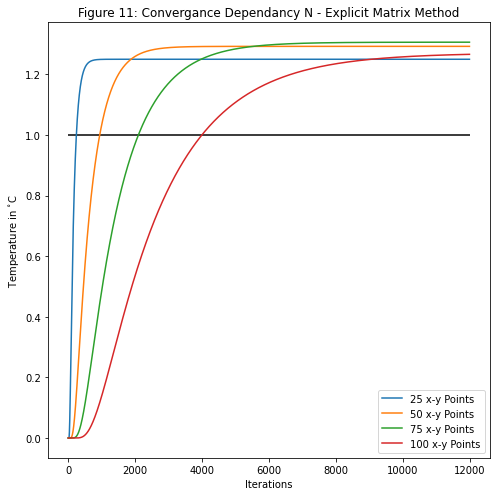

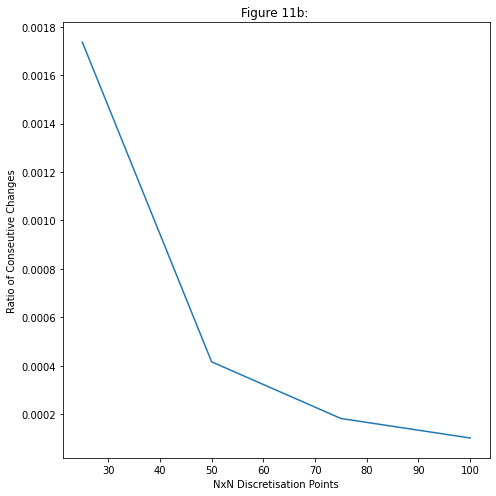

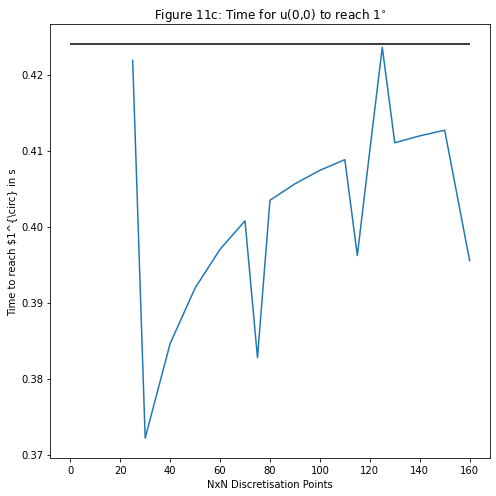

In [ ]:
Ns = [25, 50, 75, 100]
mat_time2 = []
for n in Ns:
  Mat_Ex_res, Mat_Ex_time_elapsed, Mat_Ex_count,  Mat_Ex_halfval, decimal,
                 Mat_Ex_temps = Matrix_Explicit(n, 12000, 3, False)

  plt.plot(Mat_Ex_temps, label = str(n)+" x-y Points")
  Mat_Ex_res, Mat_Ex_time_elapsed, Mat_Ex_count,  Mat_Ex_halfval, decimal,
                 Mat_Ex_temps = Matrix_Explicit(n, 12000, 3, True)

  mat_time2.append(Mat_Ex_time_elapsed/Mat_Ex_count)
plt.hlines(1, 0, 12000)
plt.title("Figure 11a: Convergance Dependancy N - Explicit Matrix Method")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Temperature in $^{\circ}$C")
plt.plot()
plt.figure()
plt.title("Figure 11b: ")
plt.xlabel("NxN Discretisation Points")
plt.ylabel("Ratio of Conseutive Changes")
plt.plot(Ns, mat_time2)

Ns = [25,30,40,50,60,70,75,80,90,100,110,115,120,125, 130, 140, 150, 160]
mat_time = []
for n in Ns:
  iteration = (10000 if n>50 else 2*(n**2))     
  #Ensures reasonable runtimes, as iter = 2 * (N**2)
  Mat_Ex_res, Mat_Ex_time_elapsed, Mat_Ex_count,  Mat_Ex_halfval, decimal, 
                          Mat_Ex_temps = Matrix_Explicit(n, iteration, 3, True)
  mat_time.append(Mat_Ex_time_elapsed)
plt.figure()
plt.title("Figure 11c: Time for u(0,0) to reach $1^{\circ}$")
plt.xlabel("NxN Discretisation Points")
plt.ylabel("Time to reach $1^{\circ} in s")
plt.hlines(0.424011387033, 0, Ns[-1])
plt.plot(Ns, mat_time)






























































































































The above method is very slow, Figure 8 needed 6 minutes to execute. This is because solving a NxN matrix requires exponentially many calculations. To improve on this, a CSR format of A is used and executed below. CSR formatting offers large benefits here as A is very sparse and has (almost) constant elements per line, so padding is minimal. Scipy's sparse solver is very fast (see Assignment 2). As Figure 11b shows, the convergence of the Explicit matrix method is very strong. Within 2000 iterations even the 100x100 (10,000) system is halfway to $1^{\circ}$ and the gradients are exactly what is expected. As different Ns change the dx, the dx vary dt through the stability formula. If N doubles to 2N, dx becomes 
$$
N -> 2N
$$
$$
dx = \frac{2}{2N-1} =\frac{1}{N-\frac{1}{2}} 
$$
which forces 
$$
dt = \frac{dx^2}{4} = \frac{\frac{2}{2N-1}^2}{4} = \frac{16}{4N^2-4N+1}
$$
which is
$$
\frac{64}{4N^4-4N^3+N^2}
$$
times larger than dt where N is not doubled. So, when N doubled, dt scales like 
$$
N -> 2N
$$
$$
dt -> \frac{64}{4N^4-4N^3+N^2} dt
$$
However, this may be simplified as
$$
dx_{2N} = \frac{2}{2N-1} \approx \frac{2}{2N} \approx \frac{1}{2}dx_{N}
$$
therefore
$$
dt_{2N} = \frac{\frac{1}{4}dx_{N}^2}{4} = \frac{dx_{N}^2}{16} = \frac{1}{4}dt_N
$$
So, doubling N halves dx, which quarters dt. This exponential reduction is what causes the smooth curve in Figure 11b.

Further looking at the time calculations, Figure 11b shows that there is a slight understatement of the times. This is likely due to the way in which the central value is returned in the function. The value is rounded to 'decimal' decimal places and then a test is ran to see if this is 1.0. There is a range of $\pm \frac{dt}{2}$ within which a True is returned so the function stops. As the value is approached from below, this means an under estimation of dt occurs. This is an improvement which could be used, simply continuing for a few more iterations would suffice. The number of additional iterations would be  $\frac{1-u(0,0)}{dt}$ (rounded up to an integer) extra.

[]

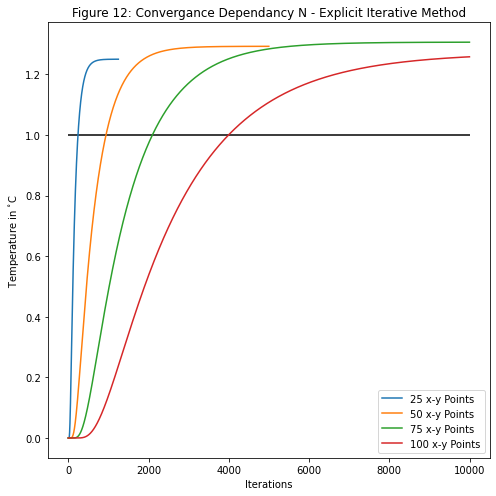

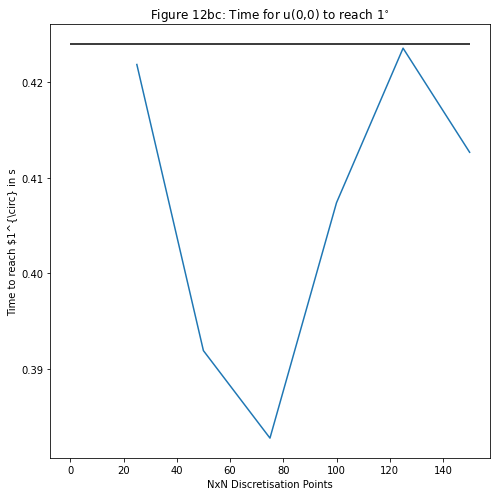

In [ ]:
Ns = [25, 50, 75, 100]
temps = []

for n in Ns:
  dt = 0.25*((n/2)**2)
  iteration = (10000 if n>50 else 2*(n**2))     
  It_Ex_res, It_Ex_time_elapsed, It_Ex_count, It_Ex_halfval, decimal, 
                It_Ex_temps = iterative_Explicit(n, iteration, 3, False)

  plt.plot(It_Ex_temps, label = str(n)+" x-y Points")

plt.hlines(1, 0, 10000)
plt.title("Figure 12: Convergance Dependancy N - Explicit Iterative Method")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Temperature in $^{\circ}$C")
plt.plot()

Ns = [25, 50, 75, 100, 125, 150]
it_time = []
for n in Ns:
  dt = 0.25*((n/2)**2)
  iteration = (10000 if n>50 else 2*(n**2))    
  It_Ex_res, It_Ex_time_elapsed, It_Ex_count, It_Ex_halfval, decimal, 
                It_Ex_temps = iterative_Explicit(n, iteration, 3, True)     
  it_time.append(It_Ex_time_elapsed)
plt.figure()
plt.title("Figure 12bc: Time for u(0,0) to reach $1^{\circ}$")
plt.xlabel("NxN Discretisation Points")
plt.ylabel("Time to reach $1^{\circ}$ in s")
plt.hlines(0.424011387033, 0, Ns[-1])
plt.plot(Ns, it_time)
plt.plot()

For the Explicit Iterative method, the convergences follow the same pattern in 'iterations to reach $1^{\circ}$, as shown in Figure 12. The convergence is very smooth and as with the Matrix Explicit method, the gradient slopes more gradually with N. One thing to note here is that the calculated times in Figure 12b show a similar pattern to Figure 13c. The time is always slightly less than the actual time of 0.424011387033s because of the rounding discussed above.

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


[]

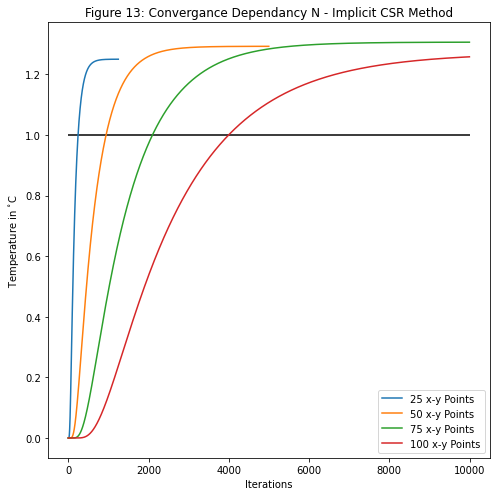

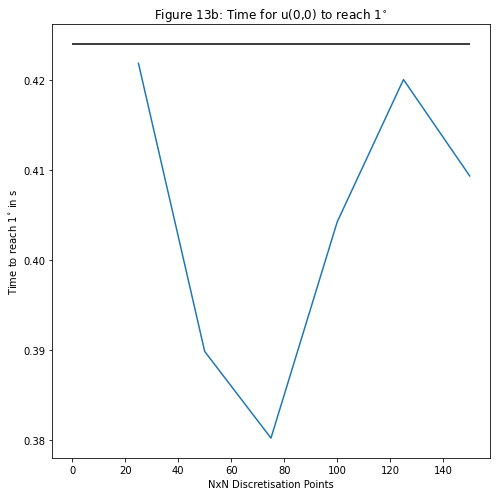

In [ ]:
Ns = [25, 50, 75, 100]
for n in Ns:
  dt = 0.0001
  iteration = (10000 if n>50 else 2*(n**2))     
  CSR_Imp_res, CSR_Imp_A, CSR_Imp_b, CSR_Imp_time_elapsed, CSR_Imp_count, 
                              CSR_Imp_half_value, CSR_Imp_temps =
                               CSR_implicit(n, dt, iteration, 2, False)

  plt.plot(CSR_Imp_temps, label = str(n)+" x-y Points")

plt.hlines(1, 0, 10000)
plt.title("Figure 13: Convergance Dependancy N - Implicit CSR Method")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Temperature in $^{\circ}$C")
plt.plot()

Ns = [25, 50, 75, 100, 125, 150]
CSR_time = []
for n in Ns:
  iteration = (10000 if n>50 else 2*(n**2))     
  CSR_Imp_res, CSR_Imp_A, CSR_Imp_b, CSR_Imp_time_elapsed, CSR_Imp_count,
                              CSR_Imp_half_value, CSR_Imp_temps = 
                              CSR_implicit(n, 0.001, iteration, 3, True)  

  CSR_time.append(CSR_Imp_time_elapsed)

plt.figure()
plt.title("Figure 13b: Time for u(0,0) to reach $1^{\circ}$")
plt.xlabel("NxN Discretisation Points")
plt.ylabel("Time to reach $1^{\circ}$ in s")
plt.hlines(0.424011387033, 0, Ns[-1])
plt.plot(Ns, CSR_time)
plt.plot()











Running the CSR Implicit method this many times required about 3 hours of calculation time. Because of this, the writer has decided not to pursue the t* limit with the CSR method. In Figure 13 the convergence follow the same convergence pattern as the previous methods, and the $t(u(0,0))$ values follow the similar drop then increase pattern.

[]

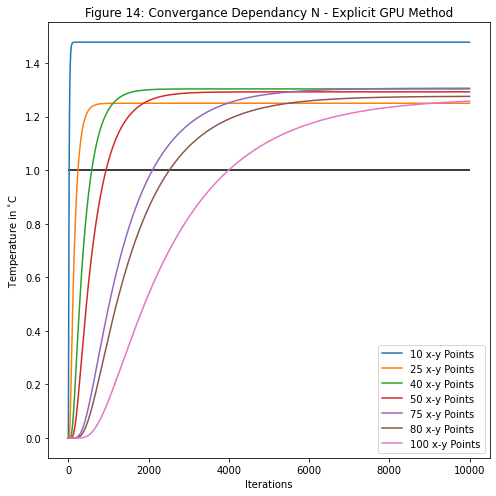

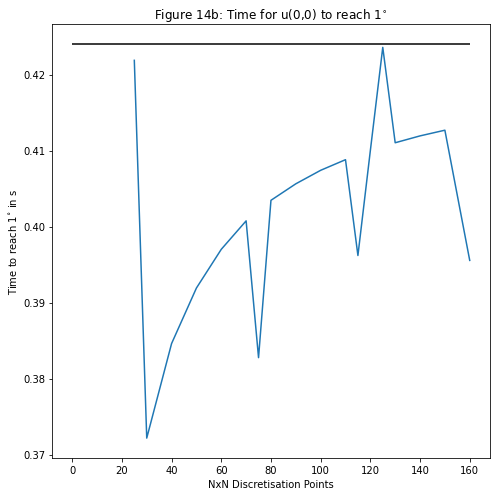

In [ ]:
Ns = [25, 50, 75, 100]
temps = []
SX = 512

for n in Ns:
  SY = SY = 4*(n-1)+5*(n-2)**2
  dt = 0.25*((n/2)**2)
  GPU_Ex_res, GPU_Ex_time_elapsed, GPU_Ex_count, GPU_Ex_round, decimal, 
                    GPU_Ex_center_temps = GPU_Explicit(n, 10000, 3, False)

  plt.plot(GPU_Ex_center_temps, label = str(n)+" x-y Points")
plt.hlines(1, 0, 10000)
plt.title("Figure 14: Convergance Dependancy N - Explicit GPU Method")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Temperature in $^{\circ}$C")


Ns = [25,30,40,50,60,70,75,80,90,100,110,115,120,125, 130, 140, 150, 160]
GPU_time = []
for n in Ns:
  SY = SY = 4*(n-1)+5*(n-2)**2
  dt = 0.25*((n/2)**2)
  GPU_Ex_res, GPU_Ex_time_elapsed, GPU_Ex_count, GPU_Ex_round, decimal,
                      GPU_Ex_center_temps = GPU_Explicit(n, 10000, 3, True)

  GPU_time.append(GPU_Ex_time_elapsed)

plt.figure()
plt.title("Figure 14b: Time for u(0,0) to reach $1^{\circ}$")
plt.xlabel("NxN Discretisation Points")
plt.ylabel("Time to reach $1^{\circ}$ in s")
plt.hlines(0.424011387033, 0, Ns[-1])
plt.plot(Ns, GPU_time)
plt.plot()











The Explicit GPU method was second fastest, and most consistent in calculation times. In Figure 14 the many curves tend to slightly different values. This is likely since dx is a function of N, therefore the 'end' temperature will be slightly different for each N value. This is also true for the Iterative and Matrix methods above. The calculated time to reach $1^{\circ}$ shows a very similar pattern to the Matrix method, as expected. Because they are identical on a theoretical level, they should yield identical results. The main difference is the speed of their implementation. A point worth noting is the 'dip' as N is between 20 and 40. This is followed by a slow increase in all cases. This is likely due to the shape of N about the center. For N = 10, the center is a very wide area covering multiples of the areas associated with N = 50 as dx scales linearly with N. This means that it is very inaccurate at N = 10 so the time that $u(0,0)=1^{\circ}$ is very  fast. However as N increases and dt shrinks quadratically, it dx maintains a linear decrease so that dt's rate over compensates. This means there is accuracy in time but inaccuracy in dx. This creates the situation where the function has precise time readings but rounds dx to a large error, creating this relationship in Figures 11c, 12b and 14b.  

#Conclusion

This problem posed several problems. Firstly, how is the matrix u modelled. The writer opted for a 3D matrix of $u[time][x][y]$ so that previous u values may be calculated upon, and no data is deleted as the iterations move through the time space. Whether to use the Forwards or Backwards Euler was another issue. In this discussion the writer decided to use the Explicit GPU implementation as it balanced speed (second fastest) with consistency. This means that although the Backward Euler methods were researched, they are not optimal for large matrices. For a discretisation of only 50x50 it required at best 1.62s (CSR) of calculation time, and at worst 101s. When running the converances, the code block took 3 hours to compute. This makes it difficult to use with fine grids, however the flexibility of using any time step may prove its useful in other areas. 

The GPU method is tested below to return the time for point u(0,0) to reach $1^{\circ}$ to 4 decimal places, i.e 0.9995... This finds teh correct t* value to 1 decimal place. The underestimate is due to the method of approximating the central point.



/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


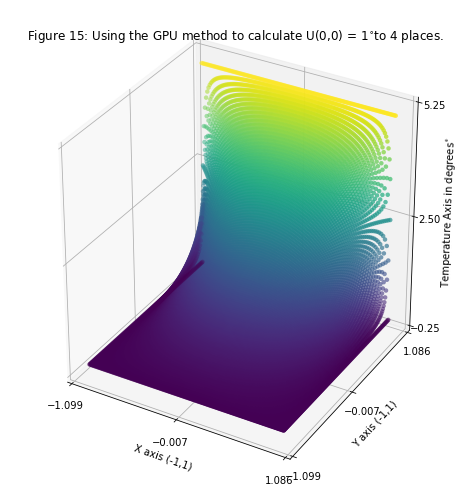

0.41304445745694784


In [ ]:
plt.rcParams["figure.figsize"] = [7.00, 7.00]
plt.rcParams["figure.autolayout"] = True

N = 150
SX = 512
SY = SY = 4*(N-1)+5*(N-2)**2
res, time_elapsed, count, temp_u0, decimal, center_temps_GPU = 
                                    GPU_Explicit(N, 2*(N**2), 4, True)

title = "Figure 15: Using the GPU method to calculate U(0,0) = $1^{\circ}$ to " 
                                                +str(decimal) + " places."
Plot_3D_Surface(res, N, True, title)
print(time_elapsed)

Finally, it was found the Explicit GPU implementation proves the most effective despite the limitations on dt. It balances speed and accuracy. The Implicit proved accurate and has greater flexibility but its slowness in solving the linear system makes it inferior on this problem.

In [ ]:
@njit(fastmath=True, parallel=True)
def create_A_implicit(N, alpha):
  """
  Inputs
    -  N = number of discretisation points per axis.
    - alpha = dt/ dx**2.
  
  This function creates the discretization matrix A as described above.
    - Please see the previous Explicit discretisation matrix 
      for identical commenting. Main difference is: alpha -> -alpha.

  Outputs:
    - A is a N**2 by N**2 matrix as derived above.
  """
  A = np.zeros((N**2, N**2))
  for n in prange(N**2):
    A[n,n] = 1+4*alpha
  for n in prange(0, N**2 -1):
    A[n, n+1] = -alpha
  for n in prange(1, N**2):
    A[n,n-1] = -alpha
  for n in prange(0, N**2 - N-1):
    A[n,n+N] = -alpha
  for n in prange(0, N**2 - N-1):
    A[n+N,n] = -alpha
  for n in prange(1+N , N**2):
    A[n,n-1] = -alpha
  for n in prange(N):
    A[n,:] = 0
    A[n,n] = 1
  for n in prange((N-1)*N, N**2):
    A[n,:] = 0
    A[n,n] = 1
  for n in prange(1,N-1):
    A[n*N,:] = A[n*N + N - 1,:] = 0
    A[n*N,n*N] = A[n*N + N - 1,n*N + N - 1] = 1
  return A

#Citations

https://www.researchgate.net/figure/The-cone-of-influence-on-solutions-to-the-wave-equation_fig3_267833123